In [1]:
from typing import List
from string import punctuation
import re
from collections import Counter
import math
import itertools
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train_text = """
Вот дом, Который построил Джек. 
А это пшеница, 
Которая в тёмном чулане хранится 
В доме, 
Который построил Джек. 
А это весёлая птица-синица, 
Которая часто ворует пшеницу, 
Которая в тёмном чулане хранится 
В доме, 
Который построил Джек.
"""
test_text = """
Вот кот, Который пугает и ловит синицу,
Которая часто ворует пшеницу,
Которая в тёмном чулане хранится
В доме, Который построил Джек.
"""

In [3]:
def tokenize_text(text: str) -> List[str]:
    tokens = ["<s>", ]
    
    tokens += [word.lower() for word in re.sub(f"[{punctuation}]", ' ', text).split()]
    
    return tokens

In [4]:
train_tokens = tokenize_text(train_text)
test_tokens = tokenize_text(test_text)

In [5]:
print("Train:", train_tokens)
print("Test:", test_tokens)

Train: ['<s>', 'вот', 'дом', 'который', 'построил', 'джек', 'а', 'это', 'пшеница', 'которая', 'в', 'тёмном', 'чулане', 'хранится', 'в', 'доме', 'который', 'построил', 'джек', 'а', 'это', 'весёлая', 'птица', 'синица', 'которая', 'часто', 'ворует', 'пшеницу', 'которая', 'в', 'тёмном', 'чулане', 'хранится', 'в', 'доме', 'который', 'построил', 'джек']
Test: ['<s>', 'вот', 'кот', 'который', 'пугает', 'и', 'ловит', 'синицу', 'которая', 'часто', 'ворует', 'пшеницу', 'которая', 'в', 'тёмном', 'чулане', 'хранится', 'в', 'доме', 'который', 'построил', 'джек']


In [6]:
def calculate_unigram_probabilities(tokens: List[str], vocab, smoothing=None, add_lambda=None):
    # If the sequence starts with sentence beginning token <s>, I skip it
    if tokens[0] == "<s>":
        tokens = tokens[1:]
    unigram_probabilities = Counter(tokens)
    
    N = len(tokens)
    for token in vocab:
        freq = unigram_probabilities.get(token, 0.)
        if smoothing is None:
            unigram_probabilities[token] = freq / N
        elif smoothing == "additive":
            unigram_probabilities[token] = (freq + add_lambda) / (N +  add_lambda * len(vocab))      
            
    return unigram_probabilities
 
        

In [7]:
def calculate_bigram_probabilities(tokens: List[str], vocab, smoothing=None, add_lambda=None):
    unigram_counter = Counter(tokens)

    num_tokens = len(tokens)
    vocab_size = len(vocab)
    # Making sure the sequence starts with the sentence beginning token
    assert tokens[0] == "<s>"
    
    bigram_probabilities = {}
    bigram_probabilities["<s>"] = Counter()
    # bigram_probabilities["<s>"][tokens[1]] = 1 
    for i, j in zip(range(num_tokens - 1), range(1, num_tokens)):
        first_token = tokens[i]
        second_token = tokens[j]
        if bigram_probabilities.get(first_token) is None:
            bigram_probabilities[first_token] = Counter()
            
        bigram_probabilities[first_token][second_token] += 1
    
    # Calculating bigram probabilities
    for first_token, second_token in itertools.product(vocab.union(set(("<s>",))), vocab):
        if bigram_probabilities.get(first_token) is not None:
            bigram_count = bigram_probabilities[first_token].get(second_token, 0)
        else:
            bigram_count = 0
            bigram_probabilities[first_token] = Counter()
        first_token_unigram_count = unigram_counter.get(first_token, 0)
        
        if smoothing is None:
            if first_token_unigram_count == 0:
                bigram_cond_p = 0.
            else:
                bigram_cond_p = bigram_count / first_token_unigram_count
        elif smoothing == "additive":
            if first_token_unigram_count == 0 and add_lambda == 0.:
                bigram_cond_p = 0.
            else:
                bigram_cond_p = (bigram_count + add_lambda) / (first_token_unigram_count + add_lambda * vocab_size)
        bigram_probabilities[first_token][second_token] = bigram_cond_p
            
    return bigram_probabilities

In [8]:
train_unigram_vocab = set(train_tokens[1:])
test_unigram_vocab = set(test_tokens[1:])
train_test_unigram_vocab = train_unigram_vocab.union(test_unigram_vocab)

### Подсчёт вероятностей униграммных моделей

* Униграммная модель без сглаживания 

* Униграммная модель со сглаживанием Лапласа ($\lambda$ = 1)

In [9]:
train_unigram_probas_no_smoothing = calculate_unigram_probabilities(tokens=train_tokens, 
                                                                    vocab=train_test_unigram_vocab)
train_unigram_probas_add1 = calculate_unigram_probabilities(tokens=train_tokens,
                                                            smoothing="additive",
                                                            add_lambda=1.,
                                                            vocab=train_test_unigram_vocab)

Проверка того, что сумма вероятностей по всем униграммам равна единице.

In [10]:
print(sum(train_unigram_probas_no_smoothing.values()))
print(sum(train_unigram_probas_add1.values()))

0.9999999999999998
0.9999999999999996


In [11]:
for k, v in list(train_unigram_probas_no_smoothing.items())[:3]:
    print(k, v)

вот 0.02702702702702703
дом 0.02702702702702703
который 0.08108108108108109


### Подсчёт вероятностей биграммных моделей

* Биграммная модель без сглаживания 

* Биграммная модель со сглаживанием Лапласа ($\lambda$ = 1)

In [12]:
train_bigram_probas_no_smoothing = calculate_bigram_probabilities(tokens=train_tokens, vocab=train_test_unigram_vocab)
train_bigram_probas_add1 = calculate_bigram_probabilities(tokens=train_tokens,
                                                            smoothing="additive",
                                                            add_lambda=1.,
                                                            vocab=train_test_unigram_vocab)

In [13]:
for k, v in list(train_bigram_probas_no_smoothing.items())[:3]:
    print(k, sum(v.values()))

<s> 1.0
вот 1.0
дом 1.0


In [14]:
for k, v in list(train_bigram_probas_add1.items())[:3]:
    print(k, sum(v.values()))

<s> 0.9999999999999996
вот 0.9999999999999996
дом 0.9999999999999996


In [15]:
EPS = 1e-12
def calculate_unigram_perplexity(text_tokens: List[str], unigram_probabilities):
    mean_log_p = 0.
    # Skipping the starting (insignificant) token <s>
    for unigram in text_tokens[1:]:
        uni_prob = unigram_probabilities[unigram]

        log_p = math.log2(uni_prob + EPS)
        mean_log_p += log_p
    # Again, the <s> token is skipped
    mean_log_p /= len(text_tokens) - 1

    return 2 ** (-mean_log_p)

In [16]:
def calculate_bigram_perplexity(text_tokens_padded: List[str], bigram_probabilities):
    text_length_with_padding = len(text_tokens_padded)
    mean_log_p = 0.

    for i, j in zip(range(text_length_with_padding - 1), range(1, text_length_with_padding)):
        first_token = text_tokens_padded[i]
        second_token = text_tokens_padded[j]
        if bigram_probabilities.get(first_token) is None:
            conditional_bigram_probability = 0.
        else:
            conditional_bigram_probability = bigram_probabilities[first_token][second_token]
        
        log_p = math.log2(conditional_bigram_probability + EPS)
        mean_log_p += log_p

    mean_log_p /= text_length_with_padding - 1
    
    return 2 ** (-mean_log_p)

### Подсчёт перплексии униграмных моделей на тестовом тексте

* Модели:

     * Биграммная модель без сглаживания 

    * Биграммная модель со сглаживанием Лапласа ($\lambda$ = 1)
* Модели обучены на тренировочной выборке

In [17]:
test_unigram_perplexity_no_smoothing = calculate_unigram_perplexity(text_tokens=test_tokens,
                                                       unigram_probabilities=train_unigram_probas_no_smoothing)
test_unigram_perplexity_add1 = calculate_unigram_perplexity(text_tokens=test_tokens,
                                                       unigram_probabilities=train_unigram_probas_add1)

In [18]:
print(test_unigram_perplexity_no_smoothing)
print(test_unigram_perplexity_add1)

6323.6054670511385
25.444076431061614


### Подсчёт перплексии биграмных моделей на тестовом тексте

* Модели:

     * Биграммная модель без сглаживания 

    * Биграммная модель со сглаживанием Лапласа ($\lambda$ = 1)
* Модели обучены на тренировочной выборке

In [19]:
test_bigram_perplexity_no_smoothing = calculate_bigram_perplexity(text_tokens_padded=test_tokens,
                                        bigram_probabilities=train_bigram_probas_no_smoothing)
test_bigram_perplexity_add1 = calculate_bigram_perplexity(text_tokens_padded=test_tokens,
                                        bigram_probabilities=train_bigram_probas_add1)

In [20]:
print(test_bigram_perplexity_no_smoothing)
print(test_bigram_perplexity_add1)

11475.58624314867
13.745677638208829


## Поиск оптимального $\lambda$ в аддитивной униграмной модели

In [30]:
best_test_uni_perplexity = 10 ** 10
best_smoothing_uni_lambda = -1.
best_train_uni_probas_lambda = None

lambda_range = np.arange(0.0, 1.01, 0.01)
unigram_perplexities_list = []
for smoothing_lambda in lambda_range:
    train_unigram_probas_lambda = calculate_unigram_probabilities(tokens=train_tokens,
                                                                smoothing="additive",
                                                                add_lambda=smoothing_lambda,
                                                                vocab=train_test_unigram_vocab)
    test_unigram_perplexity_addictive_lambda = calculate_unigram_perplexity(text_tokens=test_tokens,
                                                       unigram_probabilities=train_unigram_probas_lambda)
    unigram_perplexities_list.append(math.log10(test_unigram_perplexity_addictive_lambda))
    
    if test_unigram_perplexity_addictive_lambda < best_test_uni_perplexity:
        best_test_uni_perplexity = test_unigram_perplexity_addictive_lambda
        best_smoothing_uni_lambda = smoothing_lambda
        best_train_uni_probas_lambda = train_unigram_probas_lambda
print(f"Best smoothing lambda: {best_smoothing_uni_lambda}")
test_unigram_perplexity_addictive_lambda = calculate_unigram_perplexity(text_tokens=test_tokens,
                                                       unigram_probabilities=best_train_uni_probas_lambda)
print(f"Test perplexity with addictive unigram model (lambda = {best_smoothing_uni_lambda}): {test_unigram_perplexity_addictive_lambda}")

Best smoothing lambda: 1.0
Test perplexity with addictive unigram model (lambda = 1.0): 25.444076431061614


### График зависимости между перплексией на тестовом тексте и параметром сглаживания $\lambda$ (униграммная модель)

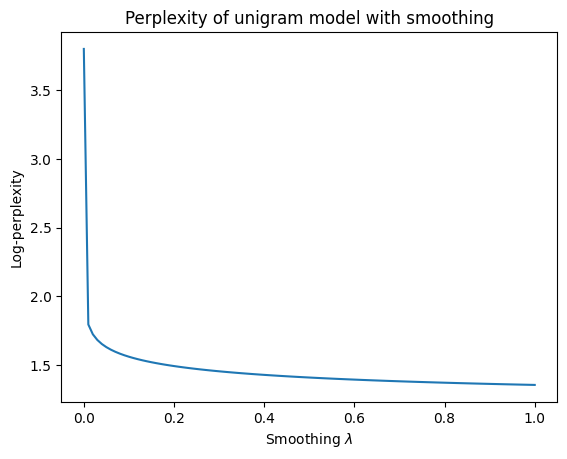

In [22]:
plt.plot(lambda_range, unigram_perplexities_list)
plt.title("Perplexity of unigram model with smoothing")
plt.xlabel("Smoothing $\lambda$")
plt.ylabel("Log-perplexity")
plt.savefig("unigram_perplexity.pdf", format="pdf")

## Поиск оптимального $\lambda$ в аддитивной биграмной модели

In [23]:
best_test_bi_perplexity = 10 ** 10
best_smoothing_bi_lambda = -1.
best_train_bi_probas_lambda = None

lambda_range = np.arange(0.0, 1.01, 0.01)
bigram_perplexities_list = []

for smoothing_lambda in lambda_range:
    train_bigram_probas_lambda = calculate_bigram_probabilities(tokens=train_tokens,
                                                                smoothing="additive",
                                                                add_lambda=smoothing_lambda,
                                                                vocab=train_test_unigram_vocab)
    test_bigram_perplexity_addictive_lambda = calculate_bigram_perplexity(text_tokens_padded=test_tokens,
                                                       bigram_probabilities=train_bigram_probas_lambda)
    bigram_perplexities_list.append(math.log10(test_bigram_perplexity_addictive_lambda))

    if test_bigram_perplexity_addictive_lambda < best_test_bi_perplexity:
        best_test_bi_perplexity = test_bigram_perplexity_addictive_lambda
        best_smoothing_bi_lambda = smoothing_lambda
        best_train_bi_probas_lambda = train_bigram_probas_lambda
print(f"Best smoothing lambda: {best_smoothing_bi_lambda}")

test_bigram_perplexity_addictive_lambda = calculate_bigram_perplexity(text_tokens_padded=test_tokens,
                                                       bigram_probabilities=best_train_bi_probas_lambda)
print(f"Test perplexity with addictive bigram model (lambda = {best_smoothing_bi_lambda}): {test_bigram_perplexity_addictive_lambda}")

Best smoothing lambda: 0.01
Test perplexity with addictive bigram model (lambda = 0.01): 4.441470579744092


### График зависимости между перплексией на тестовом тексте и параметром сглаживания $\lambda$ (биграммная модель)

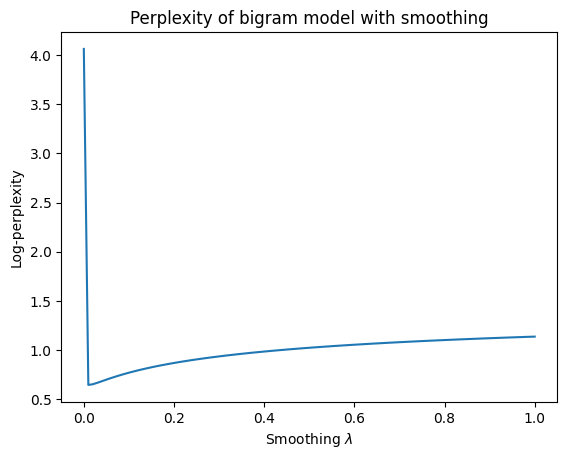

In [24]:
plt.plot(lambda_range, bigram_perplexities_list)
plt.title("Perplexity of bigram model with smoothing")
plt.xlabel("Smoothing $\lambda$")
plt.ylabel("Log-perplexity")
plt.savefig("Bigram_perplexity.pdf", format="pdf")

### Простая линейная интерполяционная модель

In [25]:
EPS = 1e-12
def calculate_uni_bi_gram_linear_model_perplexity(tokens, unigram_probabilities,
                                                 bigram_probabilities, uni_lambda):
    text_length_with_padding = len(tokens)
    mean_log_p = 0.
    for i, j in zip(range(text_length_with_padding - 1), range(1, text_length_with_padding)):
        first_token = tokens[i]
        second_token = tokens[j]
        
        if bigram_probabilities.get(first_token) is None:
            bigram_proba = 0.
        else:
            bigram_proba = bigram_probabilities[first_token][second_token]
        unigram_proba = unigram_probabilities[second_token]
        
        weighted_proba = uni_lambda * unigram_proba + (1 - uni_lambda) * bigram_proba
        log_p = math.log2(weighted_proba + EPS)
        mean_log_p += log_p
    mean_log_p /= len(tokens) - 1
    
    return 2 ** (-mean_log_p)

### Поиск оптимального веса униграммной/биграммной модели в линейной модели

In [26]:
best_linear_model_perp = 10 ** 10
best_linear_uni_weight_lambda = -1.

lambda_range = np.arange(0.0, 1.01, 0.01)
linear_model_perp_list = []

for uni_weight_lambda in lambda_range:
    linear_model_perp = calculate_uni_bi_gram_linear_model_perplexity(test_tokens,
                                                unigram_probabilities=best_train_uni_probas_lambda,
                                                bigram_probabilities=best_train_bi_probas_lambda,
                                                uni_lambda=uni_weight_lambda)
    linear_model_perp_list.append(math.log10(linear_model_perp))

    if linear_model_perp < best_linear_model_perp:
        best_linear_model_perp = linear_model_perp
        best_linear_uni_weight_lambda = uni_weight_lambda

print(f"Best unigram model's weight in linear model: {best_linear_uni_weight_lambda}")
print(f"Best linear model's perplexity: {best_linear_model_perp}")

Best unigram model's weight in linear model: 0.0
Best linear model's perplexity: 4.441470579744092


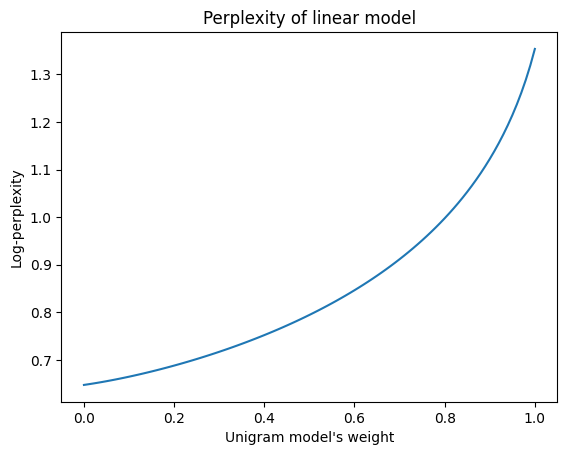

In [27]:
plt.plot(lambda_range, linear_model_perp_list)
plt.title("Perplexity of linear model")
plt.xlabel("Unigram model's weight")
plt.ylabel("Log-perplexity")
plt.savefig("linear_perplexity.pdf", format="pdf")